In [3]:
import python_read_net_images as images_set

In [5]:
#ImagesDict = images_set.GetFileStruct(r"F:\\SLABOs_image_ManualSegmented\\") 
ImagesDict = images_set.GetFileStruct(r"F:\\SLABO_MULTIRETURN_IMG\\") 

#FullMatrix = images_set.GetImageMatrix(ImagesDict)
#print("lol")

F:\\SLABO_MULTIRETURN_IMG\\0 02 25_at_16 06 49_camera-mi_182_LLT
F:\\SLABO_MULTIRETURN_IMG\\0 02 25_at_16 06 49_camera-mi_182_LLT\Fullimg
F:\\SLABO_MULTIRETURN_IMG\\0 02 25_at_16 06 49_camera-mi_182_LLT\FullLabel
F:\\SLABO_MULTIRETURN_IMG\\0 02 25_at_16 06 49_camera-mi_182_LLT\RangeImg
F:\\SLABO_MULTIRETURN_IMG\\0 04 16_at_20 50 48_camera-mi_555_LRT
F:\\SLABO_MULTIRETURN_IMG\\0 04 16_at_20 50 48_camera-mi_555_LRT\Fullimg
F:\\SLABO_MULTIRETURN_IMG\\0 04 16_at_20 50 48_camera-mi_555_LRT\FullLabel
F:\\SLABO_MULTIRETURN_IMG\\0 04 16_at_20 50 48_camera-mi_555_LRT\RangeImg
F:\\SLABO_MULTIRETURN_IMG\\2020 01 29_at_04 18 54_camera-mi_555_LRR
F:\\SLABO_MULTIRETURN_IMG\\2020 01 29_at_04 18 54_camera-mi_555_LRR\Fullimg
F:\\SLABO_MULTIRETURN_IMG\\2020 01 29_at_04 18 54_camera-mi_555_LRR\FullLabel
F:\\SLABO_MULTIRETURN_IMG\\2020 01 29_at_04 18 54_camera-mi_555_LRR\RangeImg
F:\\SLABO_MULTIRETURN_IMG\\2020 01 29_at_05 02 01_camera-mi_555_LRR
F:\\SLABO_MULTIRETURN_IMG\\2020 01 29_at_05 02 01_camera-mi

NameError: name 'MultiLabelReturnMAtrix' is not defined

In [7]:
FullMatrix, FullLabelMatrix = images_set.MultiLabelReturnMAtrix(ImagesDict)

In [8]:
import os
import re
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import mpldatacursor

import keras
import tensorflow as tf
#import keras.layers as layers
#from keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, Activation
#from tensorflow.keras.layers import Conv2D

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout, Activation
from tensorflow.keras.layers import Input,BatchNormalization,Conv2DTranspose
from tensorflow.keras.layers import concatenate

Using TensorFlow backend.


In [9]:
IMG_HEIGHT = 32
IMG_WIDTH  = 128
IMG_CHANELS = 6
img_size   = (IMG_HEIGHT, IMG_WIDTH)

In [10]:
def get_unet(num_filter = 16):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANELS))  # 32,128,2
    conv1 = Conv2D(num_filter, (3, 3), activation='relu', padding='same')(inputs) 
    conv1 = Conv2D(num_filter, (3, 3), activation='relu', padding='same')(conv1) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #use 2x2 max pool with strides=2x2 will reduce data to a half, and the output depth will not be changed
    pool1 = Dropout(0.25)(pool1)
    #16 x 64
    conv2 = Conv2D(num_filter * 2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(num_filter * 2, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)
    #8 x 32
    conv3 = Conv2D(num_filter * 4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(num_filter * 4, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)
    #4 x 16
    conv4 = Conv2D(num_filter * 8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(num_filter * 8, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)
    # 2 x 8
    conv5 = Conv2D(num_filter * 16, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(num_filter * 16, (3, 3), activation='relu', padding='same')(conv5)
    # 2 x 8
    up6   = Conv2DTranspose(num_filter * 8, (3, 3), strides=(2, 2), padding='same')(conv5) #it was 2x2 -> change it to 3x3
    up6   = concatenate([up6, conv4])
    up6   = Dropout(0.5)(up6)
    conv6 = Conv2D(num_filter * 8, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(num_filter * 8, (3, 3), activation='relu', padding='same')(conv6)

    up7   = concatenate([Conv2DTranspose(num_filter * 4, (3, 3), strides=(2, 2), padding='same')(conv6), conv3], axis=3) #change from 2x2 to 3x3
    up7   = Dropout(0.5)(up7)
    conv7 = Conv2D(num_filter * 4, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(num_filter * 4, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(num_filter * 2, (3, 3), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    up8   = Dropout(0.5)(up8)
    conv8 = Conv2D(num_filter * 2, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(num_filter * 2, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(num_filter, (3, 3), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    up9   = Dropout(0.5)(up9)
    conv9 = Conv2D(num_filter, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(num_filter, (3, 3), activation='relu', padding='same')(conv9)

    #conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    conv10 = Conv2D(3,(1,1),activation="softmax", padding="same")(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    #model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])

    return model

#The different layers in our neural network model (including convolutions, maxpooling and upsampling)

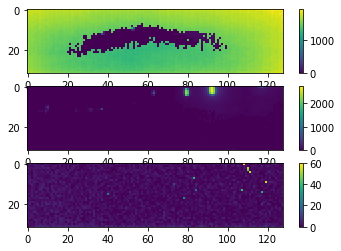

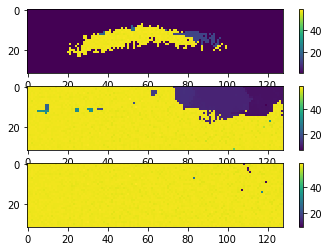

In [11]:
N = 250
plt.subplot(3, 1, 1)
plt.imshow(FullMatrix[0,N,:,:])
plt.colorbar()
plt.subplot(3, 1, 2)
plt.imshow(FullMatrix[1,N,:,:])
plt.colorbar()
plt.subplot(3, 1, 3)
plt.imshow(FullMatrix[2,N,:,:])
plt.colorbar()
plt.show()

plt.subplot(3, 1, 1)
plt.imshow(FullMatrix[3,N,:,:])
plt.colorbar()
plt.subplot(3, 1, 2)
plt.imshow(FullMatrix[4,N,:,:])
plt.colorbar()
plt.subplot(3, 1, 3)
plt.imshow(FullMatrix[5,N,:,:])
plt.colorbar()
plt.show()

In [12]:
myunet = get_unet()
myunet.summary()

W0219 11:04:31.047671  7588 deprecation.py:506] From C:\Users\uids8787\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 128, 6)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 128, 16)  880         input_1[0][0]                    
___________________________________________________________________

In [13]:

if(IMG_CHANELS == 2):
    two_channel_img = FullMatrix[0:2,:,:,:] #/65535 #np.array([int_filtered_img/65535, range_filtered_img / 65535]) 
    two_channel_img = np.moveaxis(two_channel_img,0,-1)

    mask_images = FullMatrix[4,:,:,:] #label_filtered_img.reshape(len(sublist_2_extract),32, 128, 1) # Add extra dimension for parity with train_img size [512 * 512 * 3]
    mask_images = mask_images.reshape(len(mask_images),32, 128, 1)
    print(two_channel_img.shape)
    print(mask_images.shape)

In [14]:
if(IMG_CHANELS == 4):
    four_channel_img = FullMatrix[0:4,:,:,:]   #np.array([FullMatrix[0:2,:,:,:]/65535, FullMatrix[2:4,:,:,:] ]) 
    four_channel_img[0:2,:,:,:] = four_channel_img[0:2,:,:,:] #/65535
    four_channel_img = np.moveaxis(four_channel_img,0,-1)

    print(four_channel_img.shape)


In [22]:
six_channel_img = FullMatrix   #pass the entire Matrix  0,1,2 -> intensity images while 3,4,5 -> Depth Images
six_channel_img = np.moveaxis(six_channel_img,0,-1) # -> this will move the dimension as N x 32 x128 x Channels

mask_images = FullLabelMatrix[0:3,:,:,:]  # (4,M,32,128)
mask_images = np.moveaxis(mask_images,0,-1) # -> this will move the dimension as N x 32 x128 x Channels
#mask_images = mask_images.reshape(mask_images.shape[0],32, 128,mask_images.shape[-1] ,1)

#mask_images = mask_images.reshape(len(mask_images),32, 128, 1)
print(six_channel_img.shape)
print(mask_images.shape)

(854, 32, 128, 6)
(854, 32, 128, 3)


In [24]:
#Now we have the images, we have the model lets split the set into train set and test set
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
if(IMG_CHANELS == 2):
    (trainX, testX, trainY, testY) = train_test_split(two_channel_img,mask_images, test_size=0.2, random_state=42)
elif(IMG_CHANELS == 4):
    (trainX, testX, trainY, testY) = train_test_split(four_channel_img,mask_images, test_size=0.2, random_state=42)
elif(IMG_CHANELS == 6):
    (trainX, testX, trainY, testY) = train_test_split(six_channel_img,mask_images, test_size=0.2, random_state=42)

x_valid, x_train_sub = trainX[:50,:,:,:],trainX[50:,:,:,:]
y_valid, y_train_sub = trainY[:50,:,:,:],trainY[50:,:,:,:]

# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('model-tgs-slabo.h5', verbose=1, save_best_only=True, save_weights_only=True)
         ]

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
myunet.compile(optimizer="rmsprop", loss="binary_crossentropy",metrics=["accuracy"])
#myunet.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",metrics=["accuracy"])

result = myunet.fit(trainX,trainY, batch_size=32, epochs=50, callbacks=callbacks)
#result = myunet.fit(x_train_sub,y_train_sub, batch_size=32, epochs=50, callbacks=callbacks,validation_data=(x_valid,y_valid))

 7588 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
W0219 12:00:05.989399  7588 callbacks.py:989] Can save best model only with val_loss available, skipping.
683/683 [==============================] - 16s 23ms/sample - loss: 0.4051 - acc: 0.9792
Epoch 18/50
672/683 [============================>.] - ETA: 0s - loss: 0.4034 - acc: 0.9793W0219 12:00:22.118766  7588 callbacks.py:1259] Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
W0219 12:00:22.120760  7588 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
W0219 12:00:22.121772  7588 callbacks.py:989] Can save best model only with val_loss available, skipping.
683/683 [==============================] - 16s 24ms/sample - loss: 0.4035 - acc: 0.9792
Epoch 19/50
672/683 [============================>.] - ETA: 0s - loss: 0

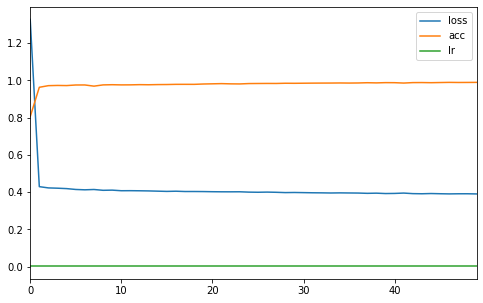

In [25]:
import pandas as pd
pd.DataFrame(result.history).plot(figsize = (8,5))
plt.show()

myunet.save('unet_slabo_6chanel_3LabelChannel_dropout-removenormalization_DatasetIncreased_3MultipleOutput_27_01_2021.h5')

In [26]:
img_result_label = myunet.predict(testX)


In [1]:
print(testX.shape)
print(img_result_label.shape)
print(testY.shape)
#print(result.shape)

NameError: name 'testX' is not defined

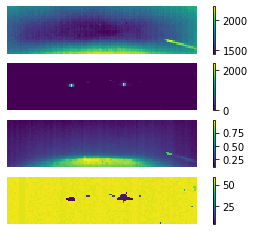

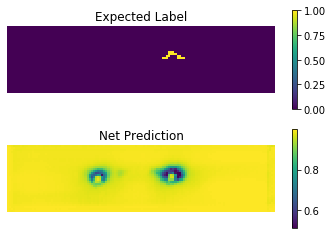

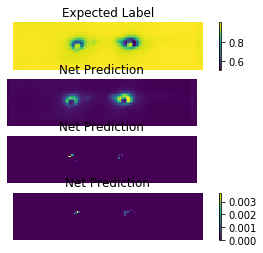

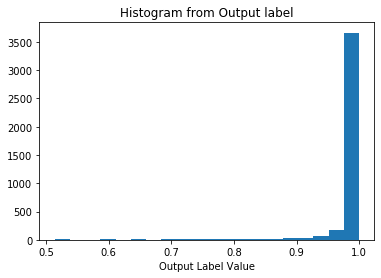

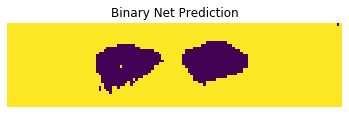

In [39]:
N = 80
L = 0
plt.subplot(4, 1, 1)
plt.imshow(testX[N,:,:,0])
plt.axis('off')
plt.colorbar()
plt.subplot(4, 1, 2)
plt.imshow(testX[N,:,:,1])
plt.axis('off')
plt.colorbar()
plt.subplot(4, 1, 3)
plt.imshow(testX[N,:,:,2])
plt.axis('off')
plt.colorbar()
plt.subplot(4, 1, 4)
plt.imshow(testX[N,:,:,3])
plt.axis('off')
plt.colorbar()
plt.show()


plt.subplot(2, 1, 1)
plt.imshow(testY[N,:,:,0])
plt.axis('off')
plt.title('Expected Label')
plt.colorbar()
plt.subplot(2, 1, 2)
plt.imshow(img_result_label[N,:,:,L])
#mpldatacursor.datacursor(hover=True, bbox=dict(alpha=1, fc='w'))
plt.axis('off')
plt.title('Net Prediction')
plt.colorbar()
plt.show()


plt.subplot(4, 1, 1)
plt.imshow(img_result_label[N,:,:,0])
plt.axis('off')
plt.title('Expected Label')
plt.colorbar()
plt.subplot(4, 1, 2)
plt.imshow(img_result_label[N,:,:,1])
#mpldatacursor.datacursor(hover=True, bbox=dict(alpha=1, fc='w'))
plt.axis('off')
plt.title('Net Prediction')
plt.subplot(4, 1, 3)
plt.imshow(img_result_label[N,:,:,2])
#mpldatacursor.datacursor(hover=True, bbox=dict(alpha=1, fc='w'))
plt.axis('off')
plt.title('Net Prediction')
plt.subplot(4, 1, 4)
plt.imshow(img_result_label[N,:,:,3])
#mpldatacursor.datacursor(hover=True, bbox=dict(alpha=1, fc='w'))
plt.axis('off')
plt.title('Net Prediction')
plt.colorbar()
plt.show()

#plot the histogram of the prediction
sliced = img_result_label[N,:,:,L]
# Multiplying arrays 
result = sliced.flatten() 

plt.hist(result[result > 0],20)
plt.xlabel('Output Label Value')
plt.title('Histogram from Output label')
plt.show()

#calculate mean, and make the binary image
binary_img = sliced > (np.mean(result[result > 0.2]))#0.03 #0.20 #sliced.mean()
plt.imshow(binary_img)
plt.axis('off')
plt.title('Binary Net Prediction')
#plt.colorbar()
plt.show()

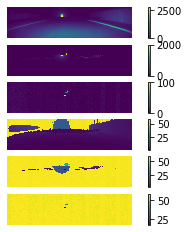

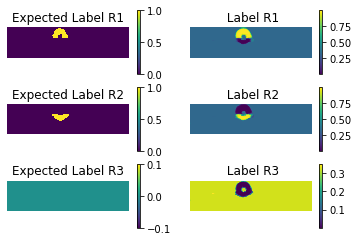

In [40]:
N = 116
L = 0
plt.subplot(6, 1, 1)
plt.imshow(testX[N,:,:,0])
plt.axis('off')
plt.colorbar()
plt.subplot(6, 1, 2)
plt.imshow(testX[N,:,:,1])
plt.axis('off')
plt.colorbar()
plt.subplot(6, 1, 3)
plt.imshow(testX[N,:,:,2])
plt.axis('off')
plt.colorbar()
plt.subplot(6, 1, 4)
plt.imshow(testX[N,:,:,3])
plt.axis('off')
plt.colorbar()
plt.subplot(6, 1, 5)
plt.imshow(testX[N,:,:,4])
plt.axis('off')
plt.colorbar()
plt.subplot(6, 1, 6)
plt.imshow(testX[N,:,:,5])
plt.axis('off')
plt.colorbar()
plt.show()

plt.subplot(3, 2, 1)
plt.imshow(testY[N,:,:,0])
plt.axis('off')
plt.title('Expected Label R1')
plt.colorbar()

plt.subplot(3, 2, 3)
plt.imshow(testY[N,:,:,1])
plt.axis('off')
plt.title('Expected Label R2')
plt.colorbar()

plt.subplot(3, 2, 5)
plt.imshow(testY[N,:,:,2])
plt.axis('off')
plt.title('Expected Label R3')
plt.colorbar()

plt.subplot(3, 2, 2)
plt.imshow(img_result_label[N,:,:,0])
plt.axis('off')
plt.title(' Label R1')
plt.colorbar()

plt.subplot(3, 2, 4)
plt.imshow(img_result_label[N,:,:,1])
plt.axis('off')
plt.title(' Label R2')
plt.colorbar()

plt.subplot(3, 2, 6)
plt.imshow(img_result_label[N,:,:,2])
plt.axis('off')
plt.title(' Label R3')
plt.colorbar()



plt.show()

In [52]:

import python_read_net_images as images_set

test_FullMatrix_img   = np.zeros((2,32,128,4))
temp = mpimg.imread(r"D:\\Nehemia\\ImageSemanticSegmentation_GUI\\0 02 25_at_16 06 49_camera-mi_182_LLT\\False\\Fullimg\\0 02 25_at_16 06 49_camera-mi_182_LLT_FALSE_frame_112_Ret1_int.png") * 65535
test_FullMatrix_img[0,:,:,0] = temp
temp = mpimg.imread(r"D:\\Nehemia\\ImageSemanticSegmentation_GUI\\0 02 25_at_16 06 49_camera-mi_182_LLT\\False\\Fullimg\\0 02 25_at_16 06 49_camera-mi_182_LLT_FALSE_frame_112_Ret2_int.png") * 65535
test_FullMatrix_img[0,:,:,1] = temp
temp = mpimg.imread(r"D:\\Nehemia\\ImageSemanticSegmentation_GUI\\0 02 25_at_16 06 49_camera-mi_182_LLT\\False\\RangeImg\\0 02 25_at_16 06 49_camera-mi_182_LLT_FALSE_frame_112_Ret1_range.png") * 65535/256
test_FullMatrix_img[0,:,:,2] = temp
temp = mpimg.imread(r"D:\\Nehemia\\ImageSemanticSegmentation_GUI\\0 02 25_at_16 06 49_camera-mi_182_LLT\\False\\RangeImg\\0 02 25_at_16 06 49_camera-mi_182_LLT_FALSE_frame_112_Ret2_range.png") * 65535/256
test_FullMatrix_img[0,:,:,3] = temp

temp = mpimg.imread(r"D:\\Nehemia\\ImageSemanticSegmentation_GUI\\0 02 25_at_16 06 49_camera-mi_182_LLT\\False\\Fullimg\\0 02 25_at_16 06 49_camera-mi_182_LLT_FALSE_frame_20409_Ret1_int.png") * 65535
test_FullMatrix_img[0,:,:,0] = temp
temp = mpimg.imread(r"D:\\Nehemia\\ImageSemanticSegmentation_GUI\\0 02 25_at_16 06 49_camera-mi_182_LLT\\False\\Fullimg\\0 02 25_at_16 06 49_camera-mi_182_LLT_FALSE_frame_20409_Ret2_int.png") * 65535
test_FullMatrix_img[0,:,:,1] = temp
temp = mpimg.imread(r"D:\\Nehemia\\ImageSemanticSegmentation_GUI\\0 02 25_at_16 06 49_camera-mi_182_LLT\\False\\RangeImg\\0 02 25_at_16 06 49_camera-mi_182_LLT_FALSE_frame_20409_Ret1_range.png") * 65535/256
test_FullMatrix_img[0,:,:,2] = temp
temp = mpimg.imread(r"D:\\Nehemia\\ImageSemanticSegmentation_GUI\\0 02 25_at_16 06 49_camera-mi_182_LLT\\False\\RangeImg\\0 02 25_at_16 06 49_camera-mi_182_LLT_FALSE_frame_20409_Ret2_range.png") * 65535/256
test_FullMatrix_img[0,:,:,3] = temp

test_FullMatrix_img.shape

(1, 32, 128, 4)

In [51]:
plt.subplot(4, 1, 1)
plt.imshow(test_FullMatrix_img[:,:,:,0])
plt.axis('off')
plt.colorbar()
plt.subplot(4, 1, 2)
plt.imshow(test_FullMatrix_img[:,:,:,1])
plt.axis('off')
plt.colorbar()
plt.subplot(4, 1, 3)
plt.imshow(test_FullMatrix_img[:,:,:,2])
plt.axis('off')
plt.colorbar()
plt.subplot(4, 1, 4)
plt.imshow(test_FullMatrix_img[:,:,:,3])
plt.axis('off')
plt.colorbar()
plt.show()

prediction =myunet.predict(test_FullMatrix_img[0,:,:,:])


plt.imshow(prediction)
#mpldatacursor.datacursor(hover=True, bbox=dict(alpha=1, fc='w'))
plt.axis('off')
plt.title('Net Prediction')
plt.colorbar()
plt.show()

TypeError: Invalid shape (1, 32, 128) for image data